# Can we get NUTS to work with GPyTorch?

Can we get HMC/NUTS to work with GPyTorch?  It's not clear that the Pyro programming language and support GPyTorch likelihood objects...

In [1]:
import gpytorch
import celerite
import pyro
import emcee
import torch
import multiprocessing
ncpus = multiprocessing.cpu_count()

In [2]:
gpytorch.__version__, celerite.__version__, pyro.__version__, emcee.__version__, torch.__version__, ncpus

('0.3.6', '0.3.1', '0.4.1', '3.0.0', '1.3.0', 8)

We'll need some other standard and astronomy-specific imports and configurations.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Generate a draw from a GP with known properties.

In [4]:
from celerite import terms

In [5]:
true_rho = 1.5
true_sigma = 1.2

In [6]:
true_log_sigma = np.log(true_sigma)
true_log_rho = np.log(true_rho)  # Has units of time, so 1/f

In [7]:
kernel_matern = terms.Matern32Term(log_sigma=true_log_sigma, log_rho=true_log_rho, eps=0.00001)

In [8]:
t_vec = np.linspace(0, 40, 500)

In [9]:
gp = celerite.GP(kernel_matern, mean=0, fit_mean=True)
gp.compute(t_vec)
y_true = gp.sample()

In [10]:
#y_true = 0.2*t_vec**2 + 0.3* t_vec - 7.0

In [11]:
noise = np.random.normal(0, 0.3, size=len(y_true))
y_obs = y_true + noise

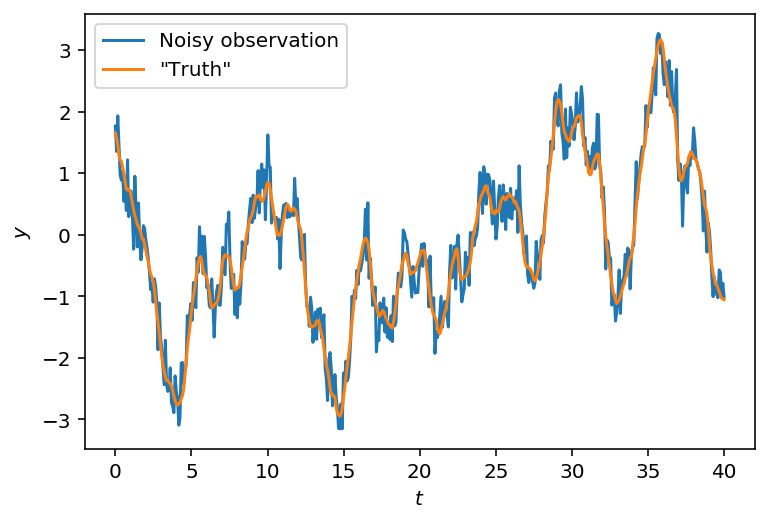

In [12]:
plt.plot(t_vec, y_obs, label='Noisy observation')
plt.plot(t_vec, y_true, label='"Truth"')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

Ok, we have a dataset to work with.

# GPyTorch model and GP likelihood building

Basic model building in GPyTorch

In [13]:
import torch

In [14]:
t_ten = torch.from_numpy(t_vec)
y_ten = torch.from_numpy(y_obs)

train_x = t_ten.to(torch.float32)
train_y = y_ten.to(torch.float32)

In [15]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [16]:
model.train()
likelihood.train();

#### Make the **marginal log likelihood**.

In [17]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

#### Initialize

In [18]:
init_dict = {'likelihood.noise_covar.raw_noise':torch.tensor([0.28]),
             'mean_module.constant':torch.tensor([0.0]),
             'covar_module.raw_outputscale': torch.tensor(1.18),
             'covar_module.base_kernel.raw_lengthscale': torch.tensor([[1.55]])}

In [19]:
model.initialize(**init_dict);

## Hamiltonian Monte Carlo with Pyro

Following:  
https://github.com/cornellius-gp/gpytorch/pull/680/files

In [20]:
import pyro
from pyro.infer.mcmc import NUTS, MCMC, HMC

In [21]:
def potential_fn(params):
    try:
        model.initialize(**params)
        output = model(train_x)
        log_joint = mll(output, train_y)
        return log_joint
    except:  # return `nan` instead of raise Value Error if not be able to get Cholesky
        r = 0
        for p in params.values():
            r = r + 0 * p.sum()
        return torch.tensor(-np.inf) + r

In [22]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([0.2800])),
             ('mean_module.constant', tensor([0.])),
             ('covar_module.raw_outputscale', tensor(1.1800)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[1.5500]]))])

In [23]:
potential_fn(model.state_dict())

tensor(-1.0459, grad_fn=<DivBackward0>)

In [24]:
hmc_kernel = HMC(model=None, potential_fn=potential_fn, step_size=0.001, adapt_step_size=False)#, full_mass=True, adapt_step_size=False, step_size=1, adapt_mass_matrix=True)

In [25]:
init_params = {k: v for k, v in model.state_dict().items()}
init_params

{'likelihood.noise_covar.raw_noise': tensor([0.2800]),
 'mean_module.constant': tensor([0.]),
 'covar_module.raw_outputscale': tensor(1.1800),
 'covar_module.base_kernel.raw_lengthscale': tensor([[1.5500]])}

In [26]:
hmc_kernel.initial_params = init_params

In [27]:
config_mcmc = MCMC(hmc_kernel, num_samples=5, warmup_steps=3,num_chains=1)

In [28]:
mcmc_run = config_mcmc.run();

Warmup:   0%|          | 0/8 [00:00<?, ?it/s]


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

Problem!